In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, \
cross_validate, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, mean_squared_error
from scipy.stats import uniform
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import seaborn as sns
from skopt.plots import plot_objective
import matplotlib.pyplot as plt
import warnings
import time as tm

In [112]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()
predictors = ['mpg', 'engineSize', 'year', 'mileage']
X_train = train[predictors]
y_train = train['price']
X_test = test[predictors]
y_test = test['price']

# Scale
sc = StandardScaler()

sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

# Case 1: No parallelization

In [113]:
time_taken_case1 = []
for i in range(50):
    start_time = tm.time()
    Ks = range(1, 20)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    cross_val_error = []
    for k in Ks:
        cross_val_error.append(-cross_val_score(KNeighborsRegressor(n_neighbors=k), 
                                                X_train_scaled, y_train, cv = kfold,
                                              scoring="neg_root_mean_squared_error").mean())
    time_taken_case1.append(tm.time() - start_time)

# Case 2: Parallelization in `cross_val_score()`

In [114]:
time_taken_case2 = []
for i in range(50):
    start_time = tm.time()
    Ks = range(1, 20)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    cross_val_error = []
    for k in Ks:
        cross_val_error.append(-cross_val_score(KNeighborsRegressor(n_neighbors=k), 
                                                X_train_scaled, y_train, cv = kfold, n_jobs = -1,
                                              scoring="neg_root_mean_squared_error").mean())
    time_taken_case2.append(tm.time() - start_time)

# Case 3: Parallelization in `KNeighborsRegressor()`

In [115]:
time_taken_case3 = []
for i in range(50):
    start_time = tm.time()
    Ks = range(1, 20)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    cross_val_error = []
    for k in Ks:
        cross_val_error.append(-cross_val_score(KNeighborsRegressor(n_neighbors=k, n_jobs= -1), 
                                                X_train_scaled, y_train, cv = kfold, 
                                              scoring="neg_root_mean_squared_error").mean())
    time_taken_case3.append(tm.time() - start_time)

# Case 4: Nested parallelization: Both `cross_val_score()` and `KNeighborsRegressor()`

In [116]:
time_taken_case4 = []
for i in range(50):
    start_time = tm.time()
    Ks = range(1, 20)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    cross_val_error = []
    for k in Ks:
        cross_val_error.append(-cross_val_score(KNeighborsRegressor(n_neighbors=k, n_jobs= -1), 
                                                X_train_scaled, y_train, cv = kfold, n_jobs = -1,
                                              scoring="neg_root_mean_squared_error").mean())
    time_taken_case4.append(tm.time() - start_time)

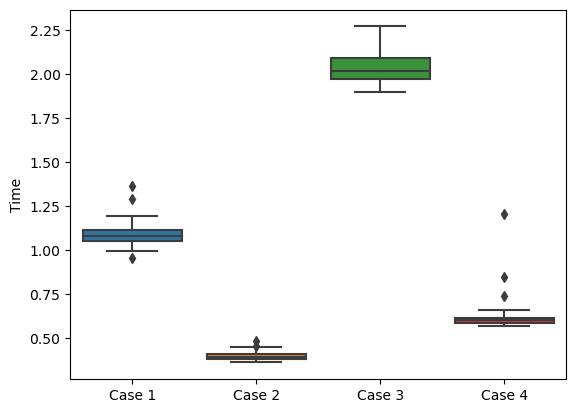

In [127]:
sns.boxplot([time_taken_case1, time_taken_case2, time_taken_case3, time_taken_case4])
plt.xticks([0, 1, 2, 3], ['Case 1', 'Case 2', 'Case 3', 'Case 4']);
plt.ylabel('Time');

# Q1
**Case 1 is without parallelization. Why is Case 3 with parallelization of `KNeighborsRegressor()` taking more time than case 1?**

# Q2
**If nested parallelization is worse than parallelization, why is case 4 with nested parallelization taking less time than case 3 with parallelization of KNeighborsRegressor()?**

# Q3
**If nested parallelization is worse than no parallelization, why is case 4 with nested parallelization taking less time than case 1 with no parallelization?**

# Q4
**If nested parallelization is the best scenario, why is case 4 with nested parallelization taking more time than case 1 with with parallelization in `cross_val_score()`?**